## Traveling Salesperson Problem with QUBO

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import networkx as nx
from time import monotonic

In [99]:
def tsp_example(points, seed):
    np.random.seed(seed)
    df=pd.DataFrame({'x': np.random.randint(0, 10000, points), 'y': np.random.randint(0, 10000, points)})
    return list([df, -1000, 11000])

def tsp_att48():
    with open('att48.txt', 'r') as file: lines=file.readlines()
    x_coor=[]
    y_coor=[]
    for i in lines:
        x, y=map(int, i.strip().split())
        x_coor.append(x)
        y_coor.append(y)
    data={'x': x_coor, 'y': y_coor}
    df=pd.DataFrame(data)
    return list([df, -400, 8300])

get_instances=tsp_example(7, 2018)
#get_instances=tsp_att48()
df=get_instances[0]
df

,x,y
0,9466,2135
1,2825,7371
2,917,3993
3,7324,3862
4,2950,4305
5,6681,7039
6,5785,1306


#### Draw a problem state

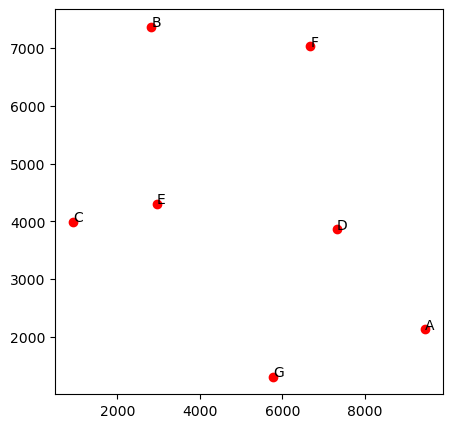

In [101]:
plt.figure(figsize=(5, 5))

city_index="ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range(len(df)):
    plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red')
    plt.text(df.iloc[i]['x']+0.69, df.iloc[i]['y']+0.69, f'{city_index[i]}')
    #plt.text(df.iloc[i]['x']+0.69, df.iloc[i]['y']+0.69, f'{i}')

plt.show()

#### Create a distance matrix

In [102]:
n_point=len(df)
time_step=n_point

d=distance_matrix(df[['x', 'y']].values, df[['x', 'y']].values, p=1)  # 1=manhattan distance, 2=euclidean distance
print(d)

[[    0. 11877. 10407.  3869.  8686.  7689.  4510.]
 [11877.     0.  5286.  8008.  3191.  4188.  9025.]
 [10407.  5286.     0.  6538.  2345.  8810.  7555.]
 [ 3869.  8008.  6538.     0.  4817.  3820.  4095.]
 [ 8686.  3191.  2345.  4817.     0.  6465.  5834.]
 [ 7689.  4188.  8810.  3820.  6465.     0.  6629.]
 [ 4510.  9025.  7555.  4095.  5834.  6629.     0.]]


### Create the $Q$ Matrix for TSP

In [103]:
class TSP_QUBO_Matrix():
    def __init__(self, n=1024):
        self.array=np.zeros((n, n), dtype=int)
        self.constant=0
        self._size=n
    
    def add_term(self, i, j, c):
        if i>=self._size or j>=self._size:
            raise RuntimeError("Wrong index")
        self.array[i][j]+=c
        
    def add_constant(self, c):
        self.constant+=c
        
    def sum(self, p):
        if self._size != p._size:
            raise RuntimeError("Wrong polynomial size")
        self.array+=p.array
        self.constant+=p.constant
        
    def power(self):
        a=np.diag(self.array)
        self.array=np.outer(a, a) + 2*self.constant*np.diag(a) # convert back to NxN
        self.constant**=2
        
    def multiply(self, p):
        a=np.diag(self.array)
        b=np.diag(p.array)
        self.array=np.outer(a, b) + self.constant*np.diag(b) + p.constant*np.diag(a)
        self.constant*=p.constant

##### $ Objective=\sum_{t=0}^{time-1}\sum_{i=0}^{city}\sum_{j=0}^{city}x_{i,t}\cdot x_{j,t+1}\cdot d_{i,j} + \sum_{i=0}^{city}\sum_{j=0}^{city}x_{i,t_{end}}\cdot x_{j,0}\cdot d_{i,j} $ (last terms for calculating Hamiltonian cycle)

In [104]:
def objective_function():
    qubo=TSP_QUBO_Matrix(n_point*time_step)
    # Ex. 3 cities iterate 0 1 2-> (0,1) (0,2) (2,0)
    for t in range(time_step):
        for i in range(n_point):
            for j in range(n_point):
                #print(city_index[i], city_index[j], t)
                if t==time_step-1: 
                    qubo.add_term((i*time_step)+t, (j*time_step), d[i][j])  # last terms that the final destination reaches the original node
                else:
                    qubo.add_term((i*time_step)+t, (j*time_step)+t+1, d[i][j])
    #print(qubo.array)
    return qubo

##### $ Constraint_{1}=\sum_{t=0}^{time}(\sum_{i=0}^{city} x_{i, t}-1)^2 $ (one-hot constraint for column)

In [105]:
def build_one_car_each_t(alpha):
    qubo=TSP_QUBO_Matrix(n_point*time_step)
    for t in range(time_step):
        tmp=TSP_QUBO_Matrix(n_point*time_step)
        for i in range(n_point):
            #print((i*time_step)+t, t)
            tmp.add_term((i*time_step)+t, (i*time_step)+t, alpha)
        tmp.add_constant(-alpha)
        tmp.power()
        qubo.sum(tmp)
        #print(tmp.array)
    #print(qubo.array)
    return qubo

##### $ Constraint_{2}=\sum_{i=0}^{city}(\sum_{t=0}^{time} x_{i, t}-1)^2 $ (one-hot constraint for row)

In [106]:
def build_car_visit_once(alpha):
    qubo=TSP_QUBO_Matrix(n_point*time_step)
    for i in range(n_point):
        tmp=TSP_QUBO_Matrix(n_point*time_step)
        for t in range(time_step):
            #print((i*time_step)+t, t)
            tmp.add_term((i*time_step)+t, (i*time_step)+t, alpha)
        tmp.add_constant(-alpha)
        tmp.power()
        qubo.sum(tmp)
        #print(tmp.array)
    #print(qubo.array)
    return qubo

In [107]:
start_time=monotonic()  # timer

Q=TSP_QUBO_Matrix(n_point*time_step)
Obj=objective_function()
C1=build_one_car_each_t(500) # column-alpha
C2=build_car_visit_once(500) # row-alpha
Q.sum(Obj)
Q.sum(C1)
Q.sum(C2)

print(f"Gen. Q time {monotonic() - start_time} seconds")
print("constant =", Q.constant)
print(Q.array)
print(f"Matrix size: {Q._size} x {Q._size}")

Gen. Q time 0.009016857999995409 seconds
constant = 3500000
[[-500000  250000  250000  250000  250000  250000  250000  250000   11877
        0       0       0       0       0  250000   10407       0       0
        0       0       0  250000    3869       0       0       0       0
        0  250000    8686       0       0       0       0       0  250000
     7689       0       0       0       0       0  250000    4510       0
        0       0       0       0]
 [ 250000 -500000  250000  250000  250000  250000  250000       0  250000
    11877       0       0       0       0       0  250000   10407       0
        0       0       0       0  250000    3869       0       0       0
        0       0  250000    8686       0       0       0       0       0
   250000    7689       0       0       0       0       0  250000    4510
        0       0       0       0]
 [ 250000  250000 -500000  250000  250000  250000  250000       0       0
   250000   11877       0       0       0       0       

In [108]:
from collections import defaultdict
Q_dwave=defaultdict(int)

for i in range(Q._size):
    for j in range(Q._size):
        if Q.array[i, j]!=0:
            Q_dwave[(i, j)]=Q.array[i, j]

print("# of terms =", len(Q_dwave))
print("# of total =", Q._size**2)
print(f'Terms = {len(Q_dwave)/(Q._size**2)}%')

# of terms = 931
# of total = 2401
Terms = 0.3877551020408163%


### Solve $x^TQx$ via D'Wave Quadratic Model

In [109]:
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler
from dimod import BinaryQuadraticModel

bqm=BinaryQuadraticModel('BINARY')
bqm=BinaryQuadraticModel.from_qubo(Q_dwave)

In [110]:
start_time=monotonic()

bqm_sampler=LeapHybridSampler()
sampleset=bqm_sampler.sample(bqm, label=f'TSP-{n_point}-QUBO', time_limit=25)
#sampleset=bqm_sampler.sample(bqm, label='ATT48-TSP-QUBO')

print(f"D-wave time {monotonic()-start_time} seconds")

D-wave time 12.502912483999808 seconds


In [111]:
print(sampleset.info)

{'qpu_access_time': 716178, 'charge_time': 24992021, 'run_time': 24992021, 'problem_id': '88d7c3eb-f413-4f3a-91d7-b596b8861b2e', 'problem_label': 'TSP-7-QUBO'}


In [112]:
best_sample=sampleset.first.sample
best_energy=sampleset.first.energy

print("Best Sample:", best_sample)
print("Best Energy:", best_energy)

# map it back to answer
solution=np.zeros(n_point*time_step, dtype=int)
for index, var in enumerate(best_sample):
    solution[index]=int(best_sample[var])

Best Sample: {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 1, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 1, 42: 0, 43: 0, 44: 0, 45: 1, 46: 0, 47: 0, 48: 0}
Best Energy: -3470522.0


In [113]:
import sys
np.set_printoptions(threshold=sys.maxsize)
#print(solution.reshape(n_point, time_step))
solution=solution.reshape(n_point, time_step)

In [114]:
def check_c1():
    for t in range(time_step):
        cnt=0
        for i in range(n_point):
            cnt+=solution[i][t]
        if cnt!=1:
            return False
    return True

def check_c2():
    for i in range(n_point):
        cnt=0
        for t in range(time_step):
            cnt+=solution[i][t]
        if cnt!=1:
            return False
    return True

In [115]:
routes=[0]*time_step
for index, (key, val) in enumerate(best_sample.items()):
    #print(index, key, val)
    if val > 0.5:
        print(f'x{index} = {val} (city: {int(index/time_step)}, time: {index%time_step})')
        routes[index%time_step]=int(index/time_step)

routes.append(routes[0])  # append for drawing graph with Hamiltonian cycle by hand
print(routes)
print("Number of visited:", len(routes))
print("Number of unique:", len(set(routes)))
print("C1:", check_c1())
print("C2:", check_c2())

x4 = 1 (city: 0, time: 4)
x7 = 1 (city: 1, time: 0)
x16 = 1 (city: 2, time: 2)
x26 = 1 (city: 3, time: 5)
x29 = 1 (city: 4, time: 1)
x41 = 1 (city: 5, time: 6)
x45 = 1 (city: 6, time: 3)
[1, 4, 2, 6, 0, 3, 5, 1]
Number of visited: 8
Number of unique: 7
C1: True
C2: True


#### Visualization

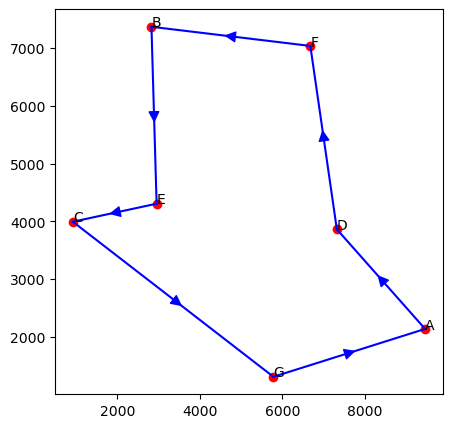

Total cost: 29478.0


In [116]:
plt.figure(figsize=(5, 5))

for i in range(len(df)):
    plt.scatter(df.iloc[i]['x'], df.iloc[i]['y'], c='red')
    plt.text(df.iloc[i]['x']+0.69, df.iloc[i]['y']+0.69, f'{city_index[i]}')
    #plt.text(df.iloc[i]['x']+0.88, df.iloc[i]['y']+0.88, f'{i}')

for i in range(len(routes)-1):
    #plt.arrow(df.iloc[routes[i]]['x'], df.iloc[routes[i]]['y'], df.iloc[routes[i+1]]['x'] - df.iloc[routes[i]]['x'], df.iloc[routes[i+1]]['y'] - df.iloc[routes[i]]['y'], 
    #head_width=2, head_length=3, fc='blue', ec='blue')
    x1, y1=df.iloc[routes[i]]['x'], df.iloc[routes[i]]['y']
    x2, y2=df.iloc[routes[i+1]]['x'], df.iloc[routes[i+1]]['y']
    plt.plot([x1, x2], [y1, y2], c='blue')

    mid_x=(x1+x2)/2
    mid_y=(y1+y2)/2
    dx=(x2-x1)*0.05  # Offset along x-direction
    dy=(y2-y1)*0.05  # Offset along y-direction
    
    #plt.annotate('', xy=(mid_x + dx, mid_y + dy), xytext=(mid_x, mid_y), arrowprops=dict(arrowstyle='->', color='blue'))
    plt.annotate('', xy=(mid_x + dx, mid_y + dy), xytext=(mid_x, mid_y),
                 arrowprops=dict(arrowstyle='simple, tail_width=0.5, head_width=0.69, head_length=0.69', color='blue'))
        
plt.show()

cost=0
for i in range(len(routes)-1):
    cost+=d[routes[i]][routes[i+1]]
print("Total cost:", cost)

#### Text optimum solution for ATT48 (only)

In [117]:
opt_seq=[0, 7, 37, 30, 43, 17, 6, 27, 5, 36, 18, 26, 16, 42, 29, 35, 45, 32, 19, 46, 20, 31, 38, 47, 4, 41, 23, 9, 44, 34, 3, 25, 1, 28, 33, 40, 15, 21, 2, 22, 13, 24, 12, 10, 11, 14, 39, 8, 0]  # from TSPLIB
opt_cost=0
for i in range(len(opt_seq)-1):
    opt_cost+=d[opt_seq[i]][opt_seq[i+1]]
print("OPTIMUM COST:", opt_cost)
#routes=opt_seq

'\nfor i in range(len(opt_seq)-1):\n    opt_cost+=d[opt_seq[i]][opt_seq[i+1]]\nprint("OPTIMUM COST:", opt_cost)\n'